# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Preprocessing 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set()

* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [27]:
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')

data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


### Deduplication


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [28]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).
* Considered score 1 and 2 as negative review and scores 4 and 5 are considered as positive review.
* For negative review '0' as label and for positive review '1' as label.

In [29]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

snow = SnowballStemmer('english')
pre_processed = []

i = 0
N = len(data['Text'])
for sentence in data['Text']:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence) 
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stopwords.words('english')]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processed.append(final_sentence)
    print("{0:.2f} %".format(i/N*100), end='\r')
    i += 1

data['Text'] = pre_processed

In [32]:
sentiment = []

for scr in data['Score']:
    if scr < 3:
        sentiment.append(0)
    else:
        sentiment.append(1)
data['Sentiment'] = sentiment

In [2]:
# loading preprocessed data from hard disk
import pickle

with open('Saved/PreProcessed.pkl', 'rb') as f:
    data = pickle.load(f)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,witti littl book make son laugh loud recit car...,1
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...,1
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,beetlejuic well written movi everyth excel act...,1
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,twist rumplestiskin captur film star michael k...,1
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,twist rumplestiskin captur film star michael k...,1


### Data Segmentation

* First 100k review taken into consideration.
* Then data is divided in 70-30 ratio for training and testing purposes.
* Data is divided according to time.

In [3]:
te = int(10000 * 7)
X_train = data['Text'][0:te]
Y_train = data['Sentiment'][0:te]
X_test = data['Text'][te:100000]
Y_test = data['Sentiment'][te:100000]

# Bag of Words

* Trained bag of words by using training data. Transformed training and testing data to numerical vectors.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [4]:
# Training Bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(max_features=2000)
bow_train = bow_model.fit_transform(X_train)
bow_test = bow_model.transform(X_test)

## Naive Bayes

* Training Naive Bayes using MultinomialNB from sklearn.naive_bayes module.
* Trained on bag of words data.

### Grid Search

* Technique for searching for optimal depth.

In [5]:
# searching for best hyperparameter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'alpha':[10**-2, 10**-1, 1, 10, 100, 1000]}
classifier_ = MultinomialNB(fit_prior=True)

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [6]:
search_hyp.fit(bow_train, Y_train)
search_hyp.best_params_

{'alpha': 0.1}

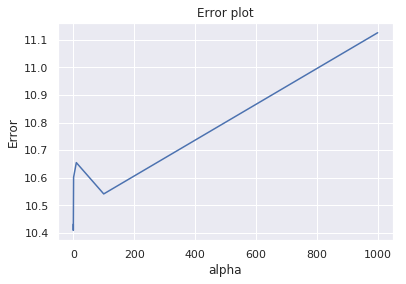

In [7]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['alpha'], test_errors)
plt.title('Error plot')
plt.xlabel('alpha')
plt.ylabel('Error') 
plt.show()

Optimal alpha is 0.01.

In [8]:
# training final model
classifier = MultinomialNB(fit_prior=True,
                           alpha=search_hyp.best_params_['alpha'])
classifier.fit(bow_train, Y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [9]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(bow_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [10]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names = ['Vectorizer', 'Search Algo', 'alpha', 'Train accuracy', 'Test accuracy',
         'Precision', 'Recall', 'f1-score']
tb.add_row(['Bag of Words', 'Grid Search', search_hyp.best_params_['alpha'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

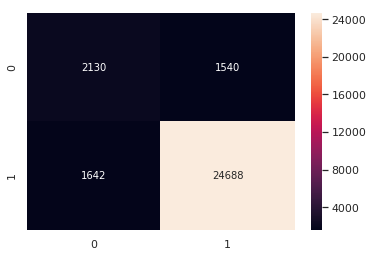

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Most Prominent Negative Review's Words


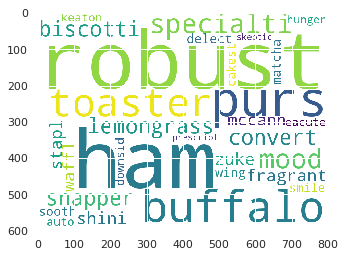

In [12]:
from wordcloud import WordCloud
print("Most Prominent Negative Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_ [0]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

Most Prominent Positive Review's Words


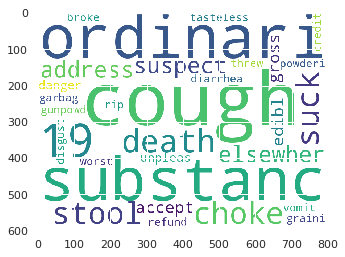

In [13]:
from wordcloud import WordCloud
print("Most Prominent Positive Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_[1]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[1][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

### Random Search

* Searching randomly for best depth.

In [14]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
alpha = np.random.uniform(low=0.001, high=0.9, size=(50,))

parameters = {'alpha':alpha}
classifier_ = classifier_ = MultinomialNB(fit_prior=True)

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [15]:
search_hyp.fit(bow_train, Y_train)
search_hyp.best_params_

{'alpha': 0.1099990697093466}

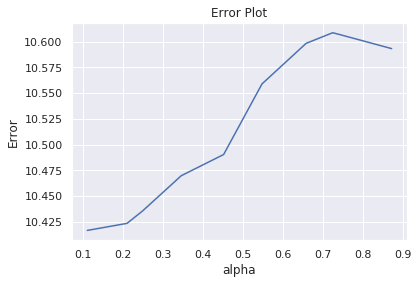

In [16]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['alpha'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("alpha")
plt.ylabel("Error")
plt.show()

Optimal alpha is 0.109.

In [17]:
# training final model
classifier = MultinomialNB(fit_prior=True,
                           alpha=search_hyp.best_params_['alpha'])
classifier.fit(bow_train, Y_train)

MultinomialNB(alpha=0.1099990697093466, class_prior=None, fit_prior=True)

In [18]:
pred = classifier.predict(bow_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [19]:
tb.add_row(['Bag of Words', 'Random Search', round(search_hyp.best_params_['alpha'],3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

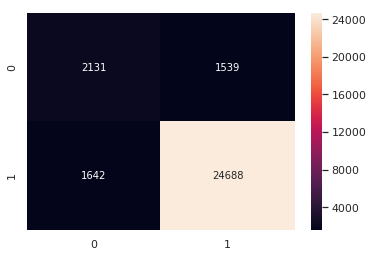

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Most Prominent Negative Review's Words


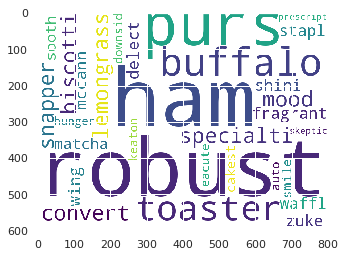

In [21]:
from wordcloud import WordCloud
print("Most Prominent Negative Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_ [0]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

Most Prominent Positive Review's Words


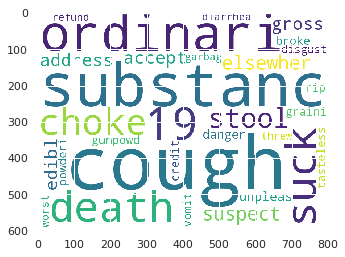

In [22]:
from wordcloud import WordCloud
print("Most Prominent Positive Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_[1]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[1][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

# Tf-Idf

* Trained tf-idf by using training data. Transformed training and testing data to numerical vectors.
* TfidfVectorizer from sklearn is used.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [23]:
# Training tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=2000)
tfidf_train = tfidf_model.fit_transform(X_train)
tfidf_test = tfidf_model.transform(X_test)

## Naive Bayes

* Training Naive Bayes using MultinomialNB from sklearn.naive_bayes module.
* Trained on tfidf data.

### Grid Search

* Technique for searching for optimal depth.

In [24]:
# searching for best hyperparameter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

parameters = {'alpha':[10**-2, 10**-1, 1, 10, 100, 1000]}
classifier_ = MultinomialNB(fit_prior=True)

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [25]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'alpha': 0.01}

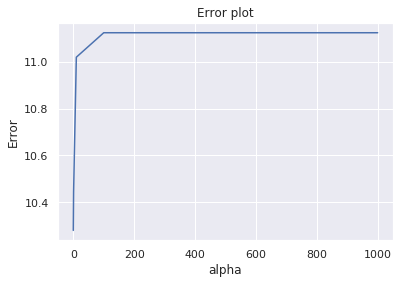

In [26]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['alpha'], test_errors)
plt.title('Error plot')
plt.xlabel('alpha')
plt.ylabel('Error') 
plt.show()

Optimal alpha is 0.01.

In [27]:
# training final model
classifier = MultinomialNB(fit_prior=True,
                           alpha=search_hyp.best_params_['alpha'])
classifier.fit(tfidf_train, Y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [28]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [29]:
tb.add_row(['Tf-idf', 'Grid Search', search_hyp.best_params_['alpha'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

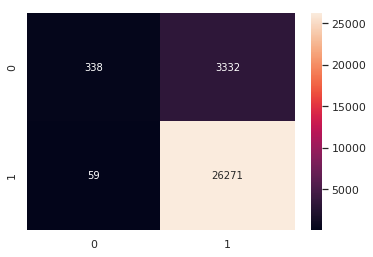

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Most Prominent Negative Review's Words


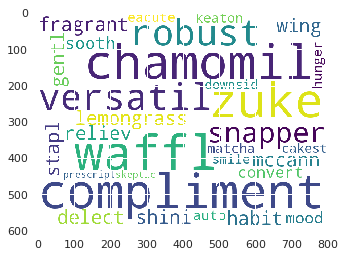

In [31]:
from wordcloud import WordCloud
print("Most Prominent Negative Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_ [0]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

Most Prominent Positive Review's Words


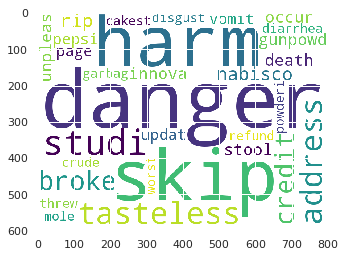

In [32]:
from wordcloud import WordCloud
print("Most Prominent Positive Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_[1]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[1][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

### Random Search

* Searching randomly for best depth.

In [33]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
alpha = np.random.uniform(low=0.001, high=0.9, size=(50,))

parameters = {'alpha':alpha}
classifier_ = classifier_ = MultinomialNB(fit_prior=True)

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [34]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'alpha': 0.008985640767020214}

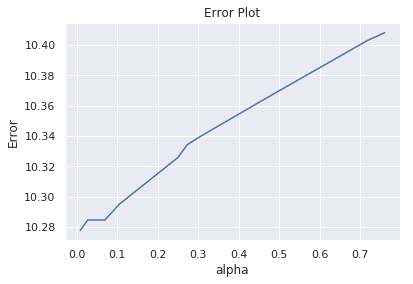

In [35]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['alpha'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("alpha")
plt.ylabel("Error")
plt.show()

Optimal alpha is 0.008.

In [36]:
# training final model
classifier = MultinomialNB(fit_prior=True,
                           alpha=search_hyp.best_params_['alpha'])
classifier.fit(tfidf_train, Y_train)

MultinomialNB(alpha=0.008985640767020214, class_prior=None, fit_prior=True)

In [37]:
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [38]:
tb.add_row(['Bag of Words', 'Grid Search', round(search_hyp.best_params_['alpha'], 3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

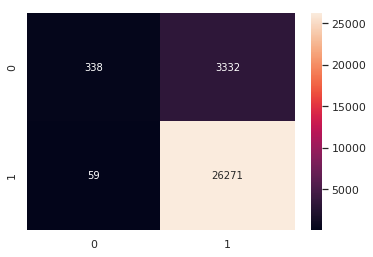

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

Most Prominent Negative Review's Words


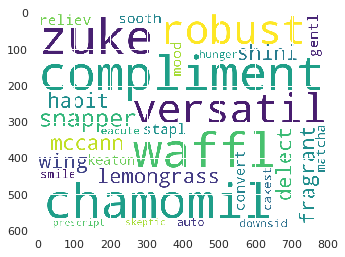

In [40]:
from wordcloud import WordCloud
print("Most Prominent Negative Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_ [0]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

Most Prominent Positive Review's Words


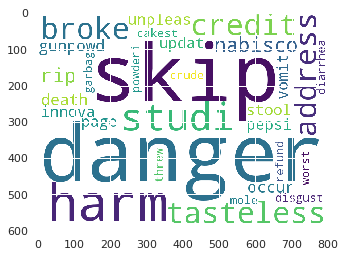

In [41]:
from wordcloud import WordCloud
print("Most Prominent Positive Review's Words")

te = {}
indices = np.array(list(map(abs, classifier.feature_log_prob_[1]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_log_prob_[1][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                min_font_size = 4).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

# Conclusion

In [42]:
# pretty table
print(tb)

+--------------+---------------+-------+----------------+---------------+-----------+--------+----------+
|  Vectorizer  |  Search Algo  | alpha | Train accuracy | Test accuracy | Precision | Recall | f1-score |
+--------------+---------------+-------+----------------+---------------+-----------+--------+----------+
| Bag of Words |  Grid Search  |  0.1  |      0.91      |      0.89     |    0.94   |  0.94  |   0.94   |
| Bag of Words | Random Search |  0.11 |      0.91      |      0.89     |    0.94   |  0.94  |   0.94   |
|    Tf-idf    |  Grid Search  |  0.01 |      0.9       |      0.89     |    0.89   |  1.0   |   0.94   |
| Bag of Words |  Grid Search  | 0.009 |      0.9       |      0.89     |    0.89   |  1.0   |   0.94   |
+--------------+---------------+-------+----------------+---------------+-----------+--------+----------+


* Got good accuracy with Naive bayes of alpha value 0.01 & 0.11 with bag of words vectorizer.
* Got high precision by using Bag of words vectorizer.
* Got high Recall by using Tf-idf vectorizer.


* Overall best model is Naive Bayes of alpha value 0.1, 0.11 with bag of words vectorizer.